# Baseline DINOv3 + kNN for the screw dataset

In [41]:
DINOV3_LOCATION = r"C:\Users\snehi\Documents\Deep Learning\dinov3"
WEIGHTS = r"C:\Users\snehi\Documents\Deep Learning\dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth"

In [42]:
import os
from glob import glob
from pathlib import Path

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

# Root folder containing the daatset mvtec_anomaly_detection
DATA_ROOT = r"C:\Users\snehi\Documents\Deep Learning\mvtec_anomaly_detection"

# Choose which class to work on (you can change to "leather", "bottle", etc.)
CLASS_NAME = "screw"

# Reuse your existing DINOv3 paths
DINOv3_REPO = DINOV3_LOCATION      # from your earlier code
DINOV3_WEIGHTS = WEIGHTS           # from your earlier code

print("DATA_ROOT:", DATA_ROOT)
print("CLASS_NAME:", CLASS_NAME)
print("DINOv3_REPO:", DINOv3_REPO)
print("DINOv3_WEIGHTS:", DINOV3_WEIGHTS)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


DATA_ROOT: C:\Users\snehi\Documents\Deep Learning\mvtec_anomaly_detection
CLASS_NAME: screw
DINOv3_REPO: C:\Users\snehi\Documents\Deep Learning\dinov3
DINOv3_WEIGHTS: C:\Users\snehi\Documents\Deep Learning\dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth
Device: cpu


For each category (CLASS_NAME = "carpet", "leather", …):

- Train:
  - Use train/good/* to build the memory bank (your current code).

- Test labels (binary):
  - test/good/* → label 0 (normal)
  - test/<color|cut|hole|metal_contamination|thread>/* → label 1 (anomaly)

In [43]:
class MVTecDataset(Dataset):
    def __init__(self, root, class_name, split="train", transform=None):
        super().__init__()
        assert split in ["train", "test"]
        self.root = root
        self.class_name = class_name
        self.split = split
        self.transform = transform

        # root/class_name/split/*/*.*
        pattern = os.path.join(root, class_name, split, "*", "*.*")
        paths = sorted(glob(pattern))

        if split == "train":
            paths = [p for p in paths if "good" in Path(p).parts]

        self.image_paths = paths

        self.labels = []
        if split == "test":
            for p in self.image_paths:
                if "good" in Path(p).parts:
                    self.labels.append(0)
                else:
                    self.labels.append(1)
        else:
            self.labels = [0] * len(self.image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img_t = self.transform(img)
        else:
            img_t = T.ToTensor()(img)

        label = self.labels[idx]
        return img_t, label, img_path


In [44]:
IMG_SIZE = 224

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])

train_dataset = MVTecDataset(DATA_ROOT, CLASS_NAME, split="train", transform=transform)
test_dataset  = MVTecDataset(DATA_ROOT, CLASS_NAME, split="test",  transform=transform)

print("Train images:", len(train_dataset))
print("Test images:", len(test_dataset))

# On Windows it's safer to use num_workers=0
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False,
                          num_workers=0, pin_memory=True)


Train images: 320
Test images: 160


In [45]:
# Count number of good (0) and defective (1) samples in test set
import numpy as np

test_labels = np.array(test_dataset.labels)
n_good = np.sum(test_labels == 0)
n_defective = np.sum(test_labels == 1)

print(f"Test set statistics for class '{CLASS_NAME}':")
print(f"  Good images     : {n_good}")
print(f"  Defective images: {n_defective}")
print(f"  Total           : {len(test_dataset)}")


Test set statistics for class 'screw':
  Good images     : 41
  Defective images: 119
  Total           : 160


## Load DINOv3 locally

In [46]:
# 1m 30s
dinov3_model = torch.hub.load(
    DINOv3_REPO,          # <- DINOV3_LOCATION
    'dinov3_vitb16',
    source='local',
    weights=DINOV3_WEIGHTS,
)
dinov3_model.eval().to(device)

print(dinov3_model)


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerN

## Feature extractor, memory bank, and visualization

In [47]:
#tranforming input from shape [B,3,H,W] to [B,D,Hf,Wf] where D is embedding dim and Hf*Wf = number of patch tokens
class DINOv3FeatureExtractor(nn.Module):
    def __init__(self, dino_model):
        super().__init__()
        self.dino = dino_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feats = self.dino.forward_features(x)
        patch_tokens = feats["x_norm_patchtokens"]  # [B, N, D]
        B, N, D = patch_tokens.shape

        side = int(N ** 0.5)
        assert side * side == N, f"Patch count {N} is not a perfect square"
        Hf = Wf = side

        patch_tokens = patch_tokens.view(B, Hf, Wf, D)
        patch_map = patch_tokens.permute(0, 3, 1, 2).contiguous()  # [B, D, Hf, Wf]
        return patch_map

feature_extractor = DINOv3FeatureExtractor(dinov3_model)
feature_extractor.eval().to(device)


DINOv3FeatureExtractor(
  (dino): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (rope_embed): RopePositionEmbedding()
    (blocks): ModuleList(
      (0-11): 12 x SelfAttentionBlock(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SelfAttention(
          (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0,

## Build the memory bank
We use the train/good to build the memory bank as they are normal images only

In [48]:
# 1m 5s
memory_bank = []

with torch.no_grad():
    for batch_idx, (imgs, labels, paths) in enumerate(train_loader):
        imgs = imgs.to(device)
        feats = feature_extractor(imgs)  # [B,D,Hf,Wf]
        B, C, Hf, Wf = feats.shape

        feats = feats.view(B, C, -1)       # [B,C,N]
        feats = feats.permute(0, 2, 1)     # [B,N,C]
        feats = feats.reshape(-1, C)       # [B*N,C]
        feats = F.normalize(feats, dim=1)  # unit norm

        memory_bank.append(feats.cpu())

memory_bank = torch.cat(memory_bank, dim=0)  # [N_mem, C]
print("Memory bank shape:", memory_bank.shape)

# Move once to the memory bank and reuse everywhere
memory_bank = memory_bank.to(device)


c:\Users\snehi\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Memory bank shape: torch.Size([62720, 768])


## Pick an anomalous test image and compute heatmap

In [49]:
# pick one anomalous test image
anomaly_indices = [i for i, lbl in enumerate(test_dataset.labels) if lbl == 1]
test_idx = anomaly_indices[-3]

img_t, label, img_path = test_dataset[test_idx]
print("Label (1=anomaly):", label)
print("Using:", img_path)

img_t_batch = img_t.unsqueeze(0).to(device)
memory_bank_device = memory_bank.to(device)

with torch.no_grad():
    feat = feature_extractor(img_t_batch)   # [1,C,Hf,Wf]
    _, C, Hf, Wf = feat.shape
    feat = feat.view(C, -1).T              # [N_patches, C]
    feat = F.normalize(feat, dim=1)

    dists = torch.cdist(feat, memory_bank_device)  # [N_patches, N_mem]

    k = 10
    dists_sorted, _ = torch.sort(dists, dim=1)
    knn_dists = dists_sorted[:, :k]
    anomaly_score_patch = knn_dists.mean(dim=1)

    anomaly_map = anomaly_score_patch.view(1, 1, Hf, Wf)

    anomaly_map = F.interpolate(
        anomaly_map,
        size=(IMG_SIZE, IMG_SIZE),
        mode="bilinear",
        align_corners=False,
    )

    anomaly_map = anomaly_map.squeeze().cpu().numpy()
    print("Anomaly map stats: min =", anomaly_map.min(),
          "max =", anomaly_map.max(), "mean =", anomaly_map.mean())


Label (1=anomaly): 1
Using: C:\Users\snehi\Documents\Deep Learning\mvtec_anomaly_detection\screw\test\thread_top\020.png
Anomaly map stats: min = 0.21627936 max = 0.6261713 mean = 0.26391733


## Overlay

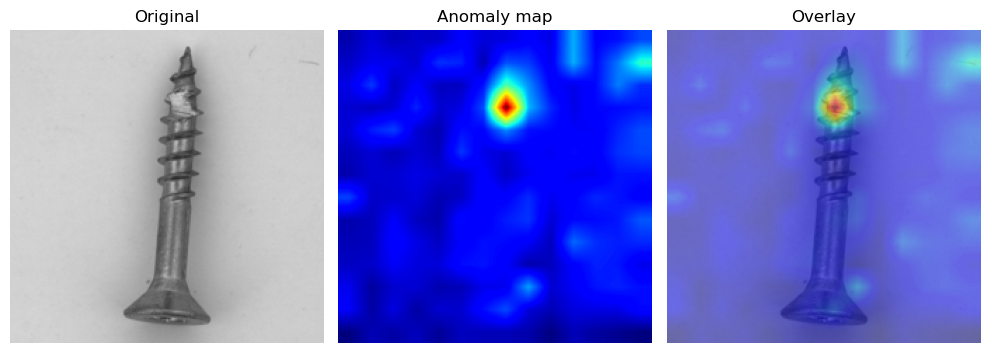

In [50]:
orig_img = Image.open(img_path).convert("RGB")
orig_img = orig_img.resize((IMG_SIZE, IMG_SIZE))
orig_np = np.array(orig_img)

anom_norm = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-8)

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.axis("off")
plt.imshow(orig_np)

plt.subplot(1, 3, 2)
plt.title("Anomaly map")
plt.axis("off")
plt.imshow(anom_norm, cmap="jet")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.axis("off")
plt.imshow(orig_np)
plt.imshow(anom_norm, cmap="jet", alpha=0.5)

plt.tight_layout()
plt.show()


## Small helper: compute anomaly map for ONE image

In [51]:
def compute_anomaly_map(img_t, feature_extractor, memory_bank, k=10):
    """
    img_t:   [3,H,W] tensor (already transformed test image)
    memory_bank: [N_mem, C] on same device as feature_extractor
    returns: anomaly_map [Hf, Wf] on CPU
    """
    img_t_batch = img_t.unsqueeze(0).to(memory_bank.device)  # [1,3,H,W]

    with torch.no_grad():
        feat = feature_extractor(img_t_batch)     # [1,C,Hf,Wf]
        _, C, Hf, Wf = feat.shape

        feat = feat.view(C, -1).T                # [N_patches, C]
        feat = F.normalize(feat, dim=1)

        dists = torch.cdist(feat, memory_bank)   # [N_patches, N_mem]

        dists_sorted, _ = torch.sort(dists, dim=1)
        knn_dists = dists_sorted[:, :k]               # [N_patches, k]
        anomaly_score_patch = knn_dists.mean(dim=1)   # [N_patches]

        anomaly_map = anomaly_score_patch.view(Hf, Wf)

    return anomaly_map.cpu()


# helper to reduce the map to a single image score
def reduce_anomaly_map(anomaly_map, mode="max"):
    """
    anomaly_map: torch.Tensor [Hf,Wf] on CPU
    mode: "max" or "mean"
    """
    if mode == "max":
        return float(anomaly_map.max().item())
    elif mode == "mean":
        return float(anomaly_map.mean().item())
    else:
        raise ValueError(f"Unknown mode: {mode}")


## Evaluation loop with ROC-AUC (memory-bank k-NN)
run over all test images, compute a score, and measure performance.

In [52]:
# 2m 

y_true = []
y_score_max = []   # using max over patches
y_score_mean = []  # using mean over patches

for i in range(len(test_dataset)):
    img_t, label, path = test_dataset[i]   # img_t: [3,H,W]
    anomaly_map = compute_anomaly_map(img_t, feature_extractor, memory_bank_device, k=10)

    score_max = reduce_anomaly_map(anomaly_map, mode="max")
    score_mean = reduce_anomaly_map(anomaly_map, mode="mean")

    y_true.append(label)
    y_score_max.append(score_max)
    y_score_mean.append(score_mean)

y_true = np.array(y_true)
y_score_max = np.array(y_score_max)
y_score_mean = np.array(y_score_mean)

auc_max = roc_auc_score(y_true, y_score_max)
auc_mean = roc_auc_score(y_true, y_score_mean)

print(f"[{CLASS_NAME}] ROC AUC (max over patches):  {auc_max:.4f}")
print(f"[{CLASS_NAME}] ROC AUC (mean over patches): {auc_mean:.4f}")


[screw] ROC AUC (max over patches):  0.8266
[screw] ROC AUC (mean over patches): 0.8014


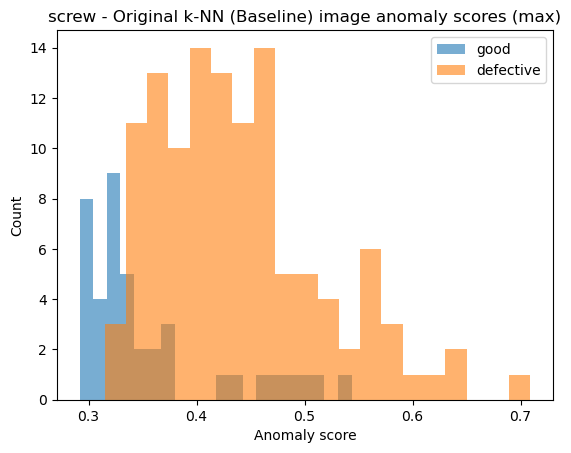

In [53]:
# histograms of scores for normal and anomalous images
import matplotlib.pyplot as plt

plt.hist(y_score_max[y_true == 0], bins=20, alpha=0.6, label="good")
plt.hist(y_score_max[y_true == 1], bins=20, alpha=0.6, label="defective")
plt.legend()
plt.title(f"{CLASS_NAME} - Original k-NN (Baseline) image anomaly scores (max)")
plt.xlabel("Anomaly score")
plt.ylabel("Count")
plt.show()


## Save heatmaps & overlays for ALL test images

In [54]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
 
def upsample_anomaly_map(anomaly_map, img_size):
    am = anomaly_map.unsqueeze(0).unsqueeze(0)  # [1,1,Hf,Wf]
    am_up = F.interpolate(
        am,
        size=(img_size, img_size),
        mode="bilinear",
        align_corners=False,
    )
    return am_up.squeeze().cpu().numpy()
 
out_root = Path("results_baseline") / CLASS_NAME   # or "results" if you prefer
heatmap_dir = out_root / "heatmaps"
overlay_dir = out_root / "overlays"
 
heatmap_dir.mkdir(parents=True, exist_ok=True)
overlay_dir.mkdir(parents=True, exist_ok=True)
 
print("Saving heatmaps to:", heatmap_dir)
print("Saving overlays to:", overlay_dir)
 
for i in range(len(test_dataset)):
    img_t, label, path = test_dataset[i]
    anomaly_map = compute_anomaly_map(img_t, feature_extractor, memory_bank, k=10)
 
    am_up = upsample_anomaly_map(anomaly_map, IMG_SIZE)
    am_norm = (am_up - am_up.min()) / (am_up.max() - am_up.min() + 1e-8)
 
    img_path = Path(path)
    orig_img = Image.open(img_path).convert("RGB")
    orig_img = orig_img.resize((IMG_SIZE, IMG_SIZE))
    orig_np = np.array(orig_img)
 
    base_name = img_path.stem
    label_str = f"label{label}"
 
    heatmap_path = heatmap_dir / f"{base_name}_{label_str}.png"
    overlay_path = overlay_dir / f"{base_name}_{label_str}.png"
 
    # heatmap
    plt.figure()
    plt.axis("off")
    plt.imshow(am_norm, cmap="jet")
    plt.tight_layout(pad=0)
    plt.savefig(heatmap_path, bbox_inches="tight", pad_inches=0)
    plt.close()
 
    # overlay
    plt.figure()
    plt.axis("off")
    plt.imshow(orig_np)
    plt.imshow(am_norm, cmap="jet", alpha=0.5)
    plt.tight_layout(pad=0)
    plt.savefig(overlay_path, bbox_inches="tight", pad_inches=0)
    plt.close()
 
print("Done saving ALL baseline heatmaps and overlays ")

Saving heatmaps to: results_baseline\screw\heatmaps
Saving overlays to: results_baseline\screw\overlays
Done saving ALL baseline heatmaps and overlays 


In [55]:
from pathlib import Path

def get_defect_type_from_path(path, class_name):
    """
    path: string or Path to a test image
    returns: defect type string, e.g. 'color', 'cut', 'hole', 'metal_contamination', 'thread', or 'good'
    """
    p = Path(path)
    parts = p.parts

    if "good" in parts:
        return "good"
    
    if "test" in parts:
        idx = parts.index("test")
        if idx + 1 < len(parts):
            return parts[idx + 1]
    return "unknown"


## load + prepare ground-truth mask

In [56]:
from PIL import Image
import numpy as np

def load_ground_truth_mask(img_path, data_root, class_name, img_size):
    """
    img_path: path of test image
    data_root: DATA_ROOT (mvtec_anomaly_detection root)
    class_name: e.g. 'carpet'
    returns: binary numpy array [img_size, img_size] with values 0 or 1
    """
    img_path = Path(img_path)
    defect_type = get_defect_type_from_path(img_path, class_name)

    if defect_type == "good":
        # normally no mask for good images
        return None

    
    stem = img_path.stem          # '000'
    mask_name = stem + "_mask.png"

    mask_path = (
        Path(data_root)
        / class_name
        / "ground_truth"
        / defect_type
        / mask_name
    )

    if not mask_path.exists():
        print("No mask found for", img_path, "expected", mask_path)
        return None

    mask = Image.open(mask_path).convert("L")  # grayscale
    # resize to same size as anomaly map /overlays
    mask = mask.resize((img_size, img_size), resample=Image.NEAREST)
    mask_np = np.array(mask)

    # MVTec masks are usually 0 (background) and 255 (defect)
    mask_bin = (mask_np > 0).astype(np.uint8)
    return mask_bin


In [57]:
# Reuse upsampling helper
import torch.nn.functional as F

def upsample_anomaly_map(anomaly_map, img_size):
    """
    anomaly_map: torch.Tensor [Hf,Wf] on CPU
    returns: numpy array [img_size, img_size]
    """
    am = anomaly_map.unsqueeze(0).unsqueeze(0)  # [1,1,Hf,Wf]
    am_up = F.interpolate(
        am,
        size=(img_size, img_size),
        mode="bilinear",
        align_corners=False,
    )
    return am_up.squeeze().cpu().numpy()


## Pixel-level AUROC over all defective images
That gives you:
- Image-level AUC (what you already have) – good vs defect classification.
- Pixel-level AUC – how well the heatmap aligns with ground-truth defect regions.

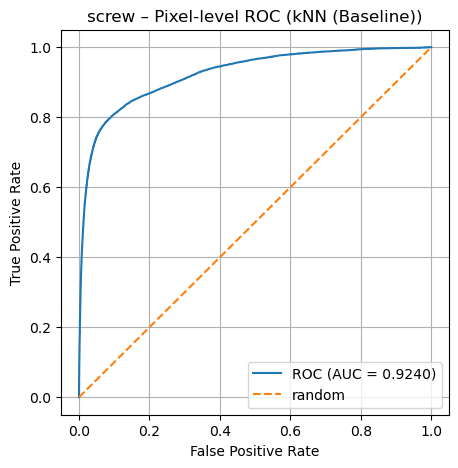

In [58]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from pathlib import Path

pixel_y_true = []    # 0/1 mask pixels
pixel_scores = []    # corresponding heatmap scores

for i in range(len(test_dataset)):
    img_t, label, path = test_dataset[i]

    # we only evaluate pixel-wise for defective images (label=1)
    if label == 0:
        continue

    # compute anomaly map as before
    anomaly_map = compute_anomaly_map(img_t, feature_extractor, memory_bank, k=10)
    am_up = upsample_anomaly_map(anomaly_map, IMG_SIZE)   # [IMG_SIZE, IMG_SIZE]

    # load and process ground truth mask
    gt_mask = load_ground_truth_mask(path, DATA_ROOT, CLASS_NAME, IMG_SIZE)
    if gt_mask is None:
        continue

    # flatten both
    pixel_y_true.append(gt_mask.flatten())
    pixel_scores.append(am_up.flatten())

# concatenate for all images
if len(pixel_y_true) == 0:
    print("No ground-truth masks found for defective images.")
else:
    pixel_y_true = np.concatenate(pixel_y_true, axis=0)
    pixel_scores = np.concatenate(pixel_scores, axis=0)

    pixel_auc = roc_auc_score(pixel_y_true, pixel_scores)
    # compute ROC curve
    fpr, tpr, _ = roc_curve(pixel_y_true, pixel_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{CLASS_NAME} – Pixel-level ROC (kNN (Baseline))")
    plt.legend()
    plt.grid(True)

    # save to results folder consistent with other outputs
    roc_dir = Path(DATA_ROOT) / "results" / CLASS_NAME
    roc_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(roc_dir / "pixel_roc.png", bbox_inches="tight", pad_inches=0)
    plt.show()

Inference times evaluation loop with ROC-AUC

In [59]:
import time

y_true = []
y_score_max = []   # using max over patches
y_score_mean = []  # using mean over patches (optional)
inference_times_baseline = []
 
for i in range(len(test_dataset)):
    img_t, label, path = test_dataset[i]   # img_t: [3,H,W]
    start = time.time()
   
    anomaly_map = compute_anomaly_map(img_t, feature_extractor, memory_bank_device, k=10)
 
    end = time.time()
 
    inference_times_baseline.append(end - start)
 
    score_max = reduce_anomaly_map(anomaly_map, mode="max")
    score_mean = reduce_anomaly_map(anomaly_map, mode="mean")
 
    y_true.append(label)
    y_score_max.append(score_max)
    y_score_mean.append(score_mean)
 
y_true = np.array(y_true)
y_score_max = np.array(y_score_max)
y_score_mean = np.array(y_score_mean)
 
auc_max = roc_auc_score(y_true, y_score_max)
auc_mean = roc_auc_score(y_true, y_score_mean)
 
avg_time_s  = float(np.mean(inference_times_baseline))
std_time_s  = float(np.std(inference_times_baseline))
avg_time_ms = avg_time_s * 1000
 
print(f"[{CLASS_NAME}] ROC AUC (max over patches):  {auc_max:.4f}")
print(f"[{CLASS_NAME}] ROC AUC (mean over patches): {auc_mean:.4f}")
 
print(f"[{CLASS_NAME}] Baseline - avg inference time:  {avg_time_ms:.2f} ms "
      f"(std = {std_time_s*1000:.2f} ms, N = {len(inference_times_baseline)})")

[screw] ROC AUC (max over patches):  0.8266
[screw] ROC AUC (mean over patches): 0.8014
[screw] Baseline - avg inference time:  1065.31 ms (std = 239.26 ms, N = 160)
